In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [16]:
data_file = '/media/amlan/Data/Thesis Data/Processed Data/train_data.csv'
df = pd.read_csv(data_file, index_col=0)
df = df.reset_index(drop=True)

df = df[df.Behavior != 'No observation']
df = df[df.VeDBA > 1e-5]
df.VeDBA  = np.log(df.VeDBA)
df = df.rename(columns={'VeDBA': 'Log VeDBA'})


df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.reset_index(drop=True)
df.Behavior.value_counts()

Scrabbling                        2822
Foraging                          1661
Bipedal vigilance                  718
Self groom                         241
Reforage                           184
Haunch quadrupedal vigilance       138
Standing quadrupedal vigilance     123
Social                             114
Running                            103
Sitting vigilance                   88
Processing                          61
Walking                             56
Marking                              4
Others                               2
Name: Behavior, dtype: int64

In [17]:
df.loc[df['Behavior'] == 'Sitting vigilance','Behavior'] = 'Vigilance'
df.loc[df['Behavior'] == 'Bipedal vigilance','Behavior'] = 'Vigilance'
df.loc[df['Behavior'] == 'Haunch quadrupedal vigilance','Behavior'] = 'Vigilance'
df.loc[df['Behavior'] == 'Standing quadrupedal vigilance','Behavior'] = 'Vigilance'

df.loc[df['Behavior'] == 'Walking','Behavior'] = 'Moving'
df.loc[df['Behavior'] == 'Running','Behavior'] = 'Moving'


df.loc[df['Behavior'] == 'Scrabbling','Behavior'] = 'Foraging' #Change

df.loc[df['Behavior'] == 'Reforage','Behavior'] = 'Foraging'

df.loc[df['Behavior'] == 'Social','Behavior'] = 'Others'
df.loc[df['Behavior'] == 'Processing','Behavior'] = 'Others'
df.loc[df['Behavior'] == 'Self groom','Behavior'] = 'Others'
df.loc[df['Behavior'] == 'Marking','Behavior'] = 'Others'

for i in df.Behavior.unique():
    print(str(i) + ' Log VeDBA Mean: ',df.loc[df['Behavior'] == str(i),'Log VeDBA'].mean())
    print(  str(i) + ' Log VeDBA Var: ',df.loc[df['Behavior'] == str(i),'Log VeDBA'].var())
    print('-----------')

Vigilance Log VeDBA Mean:  -2.857703920353857
Vigilance Log VeDBA Var:  1.151022995588004
-----------
Foraging Log VeDBA Mean:  -0.9021012234687873
Foraging Log VeDBA Var:  0.1972636471804652
-----------
Others Log VeDBA Mean:  -1.5778542980561852
Others Log VeDBA Var:  0.48227554434071657
-----------
Moving Log VeDBA Mean:  -1.051154454204253
Moving Log VeDBA Var:  1.8031307739850089
-----------


Text(0.5, 1.0, 'VeDBA Distribution Across Behavior')

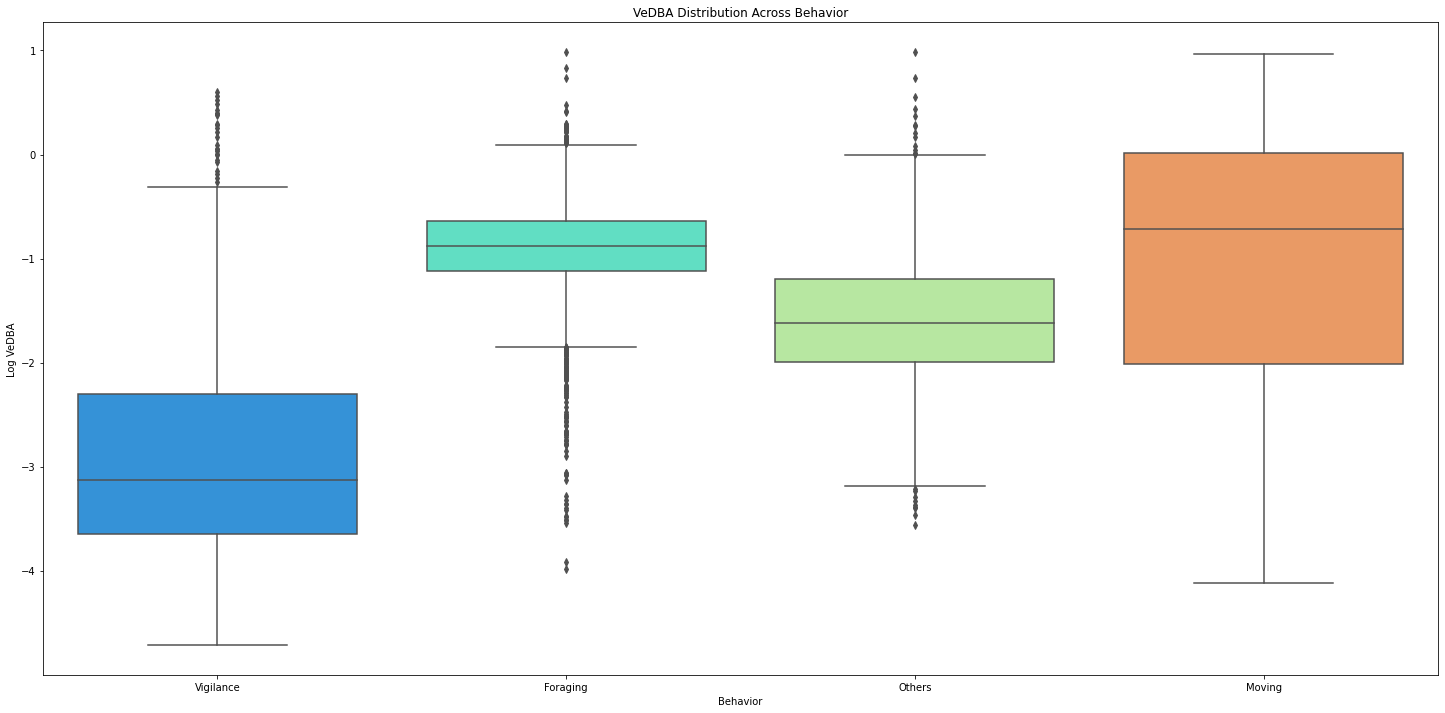

In [21]:


fig,ax = plt.subplots(figsize=(25,12))
sns.boxplot(x='Behavior',y='Log VeDBA',data=df[['Behavior','Log VeDBA','X_Mean']], palette='rainbow',showfliers=True)
plt.title("VeDBA Distribution Across Behavior")

In [22]:
#df = df.reset_index('Timestamp')
import warnings
warnings.filterwarnings('ignore')
models = [RandomForestClassifier(n_estimators=150,n_jobs=-1)]#,SVC(kernel='linear', gamma='scale'),
          #KNeighborsClassifier(n_neighbors=10)]

for k in models:
    for i in range(1,5):
        data_copy = df.copy()
        for j in range(i):
            df_ = df.iloc[:,4:].shift(periods=j)
            data_copy = pd.concat([data_copy,df_],axis=1).dropna()

        x=data_copy.iloc[:,4:]  # Features
        y=data_copy['Behavior']  # Labels

        Scaler = StandardScaler()
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=42) # 80% training and 20% test
        clf = k
            

        X_train = Scaler.fit_transform(X_train)
        clf.fit(X_train,y_train)


        X_test = Scaler.transform(X_test)
        y_pred=clf.predict(X_test)
        
        
        print(f'{k} model with {i} delay data included\n')
        print("Accuracy:",accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred))
        print('------')

        

RandomForestClassifier(n_estimators=150, n_jobs=-1) model with 1 delay data included

Accuracy: 0.9097387173396675
              precision    recall  f1-score   support

    Foraging       0.93      0.97      0.95       925
      Moving       0.81      0.44      0.57        39
      Others       0.67      0.43      0.52        79
   Vigilance       0.88      0.90      0.89       220

    accuracy                           0.91      1263
   macro avg       0.82      0.68      0.73      1263
weighted avg       0.90      0.91      0.90      1263

------
RandomForestClassifier(n_estimators=150, n_jobs=-1) model with 2 delay data included

Accuracy: 0.9168646080760094
              precision    recall  f1-score   support

    Foraging       0.93      0.98      0.95       934
      Moving       0.76      0.39      0.52        33
      Others       0.75      0.52      0.61        73
   Vigilance       0.90      0.88      0.89       223

    accuracy                           0.92      1263
  

In [ ]:
for k in models:
    for i in range(0,5):
        data_copy = df.copy()
        for j in range(i):
            df_ = df.iloc[:,4:].shift(periods=j)
            data_copy = pd.concat([data_copy,df_],axis=1).dropna()

        x=data_copy.iloc[:,4:]  # Features
        y=data_copy['Behavior']  # Labels

        scalar = StandardScaler()
        clf = k

        pipeline = Pipeline([('transformer', scalar), ('estimator', clf)])

        cv = KFold(n_splits=4)
        scores = cross_val_score(pipeline, x, y, cv = cv)
        print(f'{k} model with {i} delay data included\n')
        #print(f'Mean Accuracy: {np.mean(scores)} Std: {np.std(scores)}')
        print('-----------')